In [1]:
import json
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from adjustText import adjust_text
import scipy.stats as stf
from sklearn.metrics import r2_score

In [2]:
# Configurazione opzioni Pandas e Matplotlib

pd.set_option('display.max_columns', None)

plt.style.use('ggplot')

In [3]:
# Leggo il file di configurazione
with open('config/config.json') as f:
    config_data = json.load(f)

# Ottengo i percorsi dei file
file_path_work_vaccinazioni_covid = config_data['path_work_vaccinazioni_covid']
file_path_work_risultati_delle_elezioni_legislative_1_turno = config_data['path_work_risultati_elezioni_legislative_1_turno']
file_path_work_risultati_delle_elezioni_legislative_2_turno = config_data['path_work_risultati_elezioni_legislative_2_turno']
file_path_work_risultati_delle_elezioni_presidenziali_1_turno = config_data['path_work_risultati_elezioni_presidenziali_1_turno']
file_path_work_risultati_delle_elezioni_presidenziali_2_turno = config_data['path_work_risultati_elezioni_presidenziali_2_turno']
file_path_work_dati_sulla_disoccupazione = config_data['path_work_dati_sulla_disoccupazione']
file_path_work_reddito_per_dipartimenti = config_data['path_work_reddito_per_dipartimenti']
file_path_work_inflazione = config_data['path_work_inflazione']
file_path_work_popolazione = config_data['path_work_popolazione']

In [5]:
# Leggo i csv puliti e li carico in DataFrame di Pandas

df_risultati_elezioni_presidenziali_1_turno = pd.read_csv(file_path_work_risultati_delle_elezioni_presidenziali_1_turno,
                                                          dtype={'codice_dipartimento': str, 'codice_circoscrizione': str,
                                                                 'codice_comune': str, 'codice_seggio_elettorale': str,
                                                                 'codice_EPCI': str, 'espressi': int, '% voti/espressi': float})
df_risultati_elezioni_presidenziali_2_turno = pd.read_csv(file_path_work_risultati_delle_elezioni_presidenziali_2_turno,
                                                          dtype={'codice_dipartimento': str, 'codice_circoscrizione': str,
                                                                 'codice_comune': str, 'codice_seggio_elettorale': str,
                                                                 'codice_EPCI': str, 'espressi': int, '% voti/espressi': float})
df_risultati_elezioni_legislative_1_turno = pd.read_csv(file_path_work_risultati_delle_elezioni_legislative_1_turno,
                                                        dtype={'codice_dipartimento': str, 'codice_seggio_elettorale': str,
                                                               'codice_comune': str, 'espressi': int})
df_disoccupazione = pd.read_csv(file_path_work_dati_sulla_disoccupazione)
df_reddito_dipartimenti = pd.read_csv(file_path_work_reddito_per_dipartimenti)
df_vaccinazioni_covid = pd.read_csv(file_path_work_vaccinazioni_covid, dtype={'codice_dipartimento': str})
df_inflazione = pd.read_csv(file_path_work_inflazione)
df_popolazione = pd.read_csv(file_path_work_popolazione)

In [8]:
# Definizione funzioni ausiliarie (Query)

def calcolo_percentuale(riga):
    if riga['espressi'] != 0:
        return riga['voti']/riga['espressi']
    else:
        return 0


def get_dipartimenti_min_max_perc_voti(df_dataset, cognome=None, min=False):
    """
        Funzione che calcola la maggiore o la minore percentuale di voti per un dato candidato
    """
    
    # raggruppo i dati sulle colonne 'nome_dipartimento' e 'cognome' e ottengo la somma dei valori della colonna 'voti' e della colonna 'espressi'
    somma_voti_espressi = df_dataset.groupby(['nome_dipartimento', 'cognome'], as_index=False)[['voti', 'espressi']].sum()
    
    # filtro per cognome
    somma_voti_espressi = somma_voti_espressi[somma_voti_espressi['cognome'] == cognome]
    
    # calcolo la percentuale e ordino in maniera decrescente
    somma_voti_espressi['% voti_a_favore/voti_totali'] = somma_voti_espressi.apply(calcolo_percentuale, axis=1)
    percentuali = somma_voti_espressi.sort_values(by="% voti_a_favore/voti_totali", ascending=False)
    percentuali.reset_index(drop=True, inplace=True)
    percentuali.drop(['cognome', 'voti', 'espressi'], axis=1, inplace=True)
    
    # seleziono in base al valore di min i dipartimenti con percentuale maggiore o minore
    if min:
        display(percentuali.tail(20))
        return percentuali.tail(20)
    else:
        display(percentuali.head(20))
        return percentuali.head(20)


def differenza_presidenziali_legislative(candidati, partito):
    """
        Funzione che calcola la differenza in valore assoluto tra i voti espressi per uno o più candidati alle presidenziali 
        e i voti espressi per il relativo partito alle legislative
    """

    # filtra i dataframe sui candidati/partito di interesse
    df_presidenziali_candidati = df_risultati_elezioni_presidenziali_1_turno[df_risultati_elezioni_presidenziali_1_turno['cognome'].isin(candidati)]
    df_legislative_partito = df_risultati_elezioni_legislative_1_turno[df_risultati_elezioni_legislative_1_turno['partito'] == partito]

    # somma i voti espressi per ogni dipartimento
    somma_voti_presidenziali = df_presidenziali_candidati.groupby('nome_dipartimento', as_index=False)[['voti', 'espressi']].sum()
    somma_voti_presidenziali['% voti_a_favore/voti_totali'] = somma_voti_presidenziali.apply(calcolo_percentuale, axis=1)
    somma_voti_legislative = df_legislative_partito.groupby('nome_dipartimento', as_index=False)[['voti', 'espressi']].sum()
    somma_voti_legislative['% voti_a_favore/voti_totali'] = somma_voti_legislative.apply(calcolo_percentuale, axis=1)

    # merge dei due dataframe in base al dipartimento
    df_merged = pd.merge(somma_voti_presidenziali, somma_voti_legislative, on='nome_dipartimento', suffixes=('_presidenziali', '_legislative'))
    # aggiunge una colonna al dataset con il calcolo della differenza voti
    df_merged['% differenza_voti'] = abs(df_merged['% voti_a_favore/voti_totali_presidenziali'] - df_merged['% voti_a_favore/voti_totali_legislative'])
    # ordina il dataframe per differenza voti decrescente
    df_merged = df_merged.sort_values(by='% differenza_voti', ascending=False)
    df_merged.reset_index(drop=True, inplace=True)
    df_merged.drop(['voti_presidenziali', 'voti_legislative', 'espressi_presidenziali', 'espressi_legislative', '% voti_a_favore/voti_totali_presidenziali', '% voti_a_favore/voti_totali_legislative'], axis=1, inplace=True)
    display(df_merged.head(10))

    return df_merged

In [19]:
# Definizione funzioni ausiliarie (Correlazioni)

def calcola_correlazione(x, y, x_label, y_label, etichette_dipartimenti=False):
    """
        Funzione che calcola i coefficienti di correlazione per i vettori di dati inseriti,
        e disegna il grafico dei dati e della loro regressione lineare,
        etichettando o meno i dati con i nomi dei dipartimenti
    """
    
    slope, intercept, r, p, stderr = stf.linregress(x, y)
    line = f'Retta di regressione: y = {intercept:.2f} + {slope:.2f}x'
    if etichette_dipartimenti:
        fig, ax = plt.subplots(figsize=(16, 10))
    else:
        fig, ax = plt.subplots()
    ax.plot(x, y, linewidth=0, marker='o', label='Dati', color="#E56234")
    ax.plot(x, intercept + slope * x, label=line, color="#39A9DB")
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.xaxis.label.set_color('black')
    ax.yaxis.label.set_color('black')
    ax.legend(facecolor='white')

    if etichette_dipartimenti:
        # Aggiungi le label ai punti
        texts = []
        for index, row in df_final.iterrows():
            texts.append(ax.text(x[index], y[index], row['nome_dipartimento'], ha='center', va='bottom'))
        # Ottimizza il posizionamento delle label
        adjust_text(texts)

    r = x.corr(y, method='pearson')
    rho = x.corr(y, method='spearman')
    tau = x.corr(y, method='kendall')
    y_pred = intercept + slope * x
    y_true = y
    r2 = r2_score(y_true, y_pred)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    pearson_r = Line2D([0], [0], label=f'Indice di correlazione di Pearson      r={r:.2f}', marker='s', markersize=0.01, markeredgecolor='gray',
                       markerfacecolor='gray', linestyle='')
    spearman_rho = Line2D([0], [0], label=f'Indice di correlazione di Spearman  ρ={rho:.2f}', marker='s', markersize=0.01, markeredgecolor='gray',
                          markerfacecolor='gray', linestyle='')
    kendall_tau = Line2D([0], [0], label=f'Indice di correlazione di Kendall       τ={tau:.2f}', marker='s', markersize=0.01, markeredgecolor='gray',
                         markerfacecolor='gray', linestyle='')
    determination_r2 = Line2D([0], [0], label=f'Coefficiente di determinazione       R²={r2:.2f}', marker='s', markersize=0.01, markeredgecolor='gray',
                              markerfacecolor='gray', linestyle='')
    handles.extend([pearson_r, spearman_rho, kendall_tau, determination_r2])
    plt.legend(handles=handles)
    plt.savefig('figura.svg', format='svg')
    plt.show()


def get_correlazione(df, colonna, scelta_y, x_label, y_label, is_legislative=False, etichette_dipartimenti=False):
    """
        Funzione che filtra i DataFrame relativi a elezioni legislative o presidenziali, in base al partito o al candidato,
        e richiama la funzione per il calcolo della correlazione tra essi e un secondo DataFrame
    """
    if is_legislative:
        col = 'partito'
    else:
        col = 'cognome'
        
    somma_voti_espressi = df.groupby(['nome_dipartimento', col], as_index=False)[['voti','espressi']].sum()
    somma_voti_espressi = somma_voti_espressi[somma_voti_espressi[col] == colonna]
    somma_voti_espressi['% voti_a_favore/voti_totali'] = somma_voti_espressi.apply(calcolo_percentuale, axis=1)
    df_voti = somma_voti_espressi.copy(deep=True)
    df_voti.reset_index(drop=True, inplace=True)

    if scelta_y == 'disoccupazione':
        primo_trimestre = df_disoccupazione[(pd.to_datetime(df_disoccupazione['data']).dt.year == 2022 ) & (pd.to_datetime(df_disoccupazione['data']).dt.quarter == 1)]
        primo_trimestre_sum = primo_trimestre.groupby('nome_dipartimento')['numero_medio_persone_cercanti_lavoro'].sum()
        trimestri_successivi = df_disoccupazione[(pd.to_datetime(df_disoccupazione['data']).dt.year == 2022 ) & (pd.to_datetime(df_disoccupazione['data']).dt.quarter > 1)]
        trimestri_successivi_sum = trimestri_successivi.groupby('nome_dipartimento')['differenza_con_cercanti_lavoro_trimestre_prec'].sum()
        risultato = pd.merge(primo_trimestre_sum, trimestri_successivi_sum, on='nome_dipartimento')
        risultato = pd.merge(risultato, df_popolazione, on='nome_dipartimento')
        risultato['disoccupazione_totale'] = (risultato['numero_medio_persone_cercanti_lavoro'] + risultato['differenza_con_cercanti_lavoro_trimestre_prec']) /risultato['popolazione'] * 100
        df_final = risultato.reset_index()
        col_y = 'disoccupazione_totale'
    elif scelta_y == 'vaccinazioni':
        dati_tutte_eta = df_vaccinazioni_covid[df_vaccinazioni_covid['etichetta_variabile'] == 'Tous âges']
        df_final = dati_tutte_eta.groupby(['nome_dipartimento'], as_index=False)['copertura_vaccinale_seconda_dose'].max()
        col_y = 'copertura_vaccinale_seconda_dose'
    elif scelta_y == 'reddito_pro_capite':
        df_reddito = df_reddito_dipartimenti.copy(deep=True)
        df_final = df_reddito.astype({"reddito_pro_capite": float})
        df_final.reset_index(drop=True, inplace=True)
        col_y = 'reddito_pro_capite'
    else:
        print('I soli valori possibili di scelta_y sono: disoccupazione, vaccinazioni o reddito_pro_capite')
        return

    #display(df_final)
    df_merge = pd.merge(df_voti, df_final, on='nome_dipartimento')
    #display(df_merge)

    x = df_merge['% voti_a_favore/voti_totali']
    y = df_merge[col_y]

    calcola_correlazione(x, y, x_label, y_label, etichette_dipartimenti)

In [ ]:
# Query n.1

# • I 20 dipartimenti con la maggiore percentuale di voti per Macron
#     • Primo e secondo turno

print('Primo turno')
lista_dipartimenti_1_turno_max_macron = get_dipartimenti_min_max_perc_voti(df_risultati_elezioni_presidenziali_1_turno, cognome='MACRON')

print('Secondo turno')
lista_dipartimenti_2_turno_max_macron = get_dipartimenti_min_max_perc_voti(df_risultati_elezioni_presidenziali_2_turno, cognome='MACRON')

In [ ]:
# Query n.2

# I 20 dipartimenti con la minore percentuale di voti per Macron
#     • Primo e secondo turno

print('Primo turno')
lista_dipartimenti_1_turno_min_macron = get_dipartimenti_min_max_perc_voti(df_risultati_elezioni_presidenziali_1_turno, cognome='MACRON', min=True)

print('Secondo turno')
lista_dipartimenti_2_turno_min_macron = get_dipartimenti_min_max_perc_voti(df_risultati_elezioni_presidenziali_2_turno, cognome='MACRON', min=True)

In [ ]:
# Query n.3

# I 20 dipartimenti con la maggiore percentuale di voti per Marine Le Pen
#    • Primo e secondo turno

print('Primo turno')
lista_dipartimenti_1_turno_max_lepen = get_dipartimenti_min_max_perc_voti(df_risultati_elezioni_presidenziali_1_turno, cognome = 'LE PEN')

print('Secondo turno')
lista_dipartimenti_2_turno_max_lepen = get_dipartimenti_min_max_perc_voti(df_risultati_elezioni_presidenziali_2_turno, cognome = 'LE PEN')

In [ ]:
# Query n.4

# I 20 dipartimenti con la minore percentuale di voti per Marine Le Pen
#     • Primo e secondo turno

print('Primo turno')
lista_dipartimenti_1_turno_min_lepen = get_dipartimenti_min_max_perc_voti(df_risultati_elezioni_presidenziali_1_turno, cognome = 'LE PEN', min = True)

print('Secondo turno')
lista_dipartimenti_2_turno_min_lepen = get_dipartimenti_min_max_perc_voti(df_risultati_elezioni_presidenziali_2_turno, cognome = 'LE PEN', min = True)

In [ ]:
# Query n.5

# I 20 dipartimenti con la maggiore percentuale di voti per Jean-Luc Melenchon
#     • Primo turno

print('Primo turno')
lista_dipartimenti_1_turno_max_melanchon = get_dipartimenti_min_max_perc_voti(df_risultati_elezioni_presidenziali_1_turno, cognome = 'MÉLENCHON')

In [30]:
# Query n.6 e n.7

# I 20 dipartimenti con la maggiore e la minore disoccupazione

#seleziono il primo trimestre del 2022 e sommo il numero di persone in cerca di lavoro
primo_trimestre = df_disoccupazione[(pd.to_datetime(df_disoccupazione['data']).dt.year == 2022 ) & (pd.to_datetime(df_disoccupazione['data']).dt.quarter == 1)]
primo_trimestre_sum = primo_trimestre.groupby('nome_dipartimento')['numero_medio_persone_cercanti_lavoro'].sum()

#seleziono i restanti trimestri del 2022 e sommo la differenza delle persone in cerca di lavoro rispetto al trimestre precedente
trimestri_successivi = df_disoccupazione[(pd.to_datetime(df_disoccupazione['data']).dt.year == 2022 ) & (pd.to_datetime(df_disoccupazione['data']).dt.quarter > 1)]
trimestri_successivi_sum = trimestri_successivi.groupby('nome_dipartimento')['differenza_con_cercanti_lavoro_trimestre_prec'].sum()

#unisco i dati e sommo il numero di disoccupati al primo trimeste con la somma delle differenze
risultato_disoccupazione = pd.merge(primo_trimestre_sum, trimestri_successivi_sum, on='nome_dipartimento')
risultato_disoccupazione = pd.merge(risultato_disoccupazione, df_popolazione, on='nome_dipartimento')
risultato_disoccupazione['disoccupazione_totale'] = (risultato_disoccupazione['numero_medio_persone_cercanti_lavoro'] + risultato_disoccupazione['differenza_con_cercanti_lavoro_trimestre_prec']) / risultato_disoccupazione['popolazione'] * 100

#seleziono i 20 dipartimenti con la maggiore e minore disoccupazione totale
risultato_top_20 = risultato_disoccupazione.nlargest(20, 'disoccupazione_totale')
risultato_bottom_20 = risultato_disoccupazione.nsmallest(20, 'disoccupazione_totale')
risultato_top_20.reset_index(inplace=True)
risultato_top_20.drop(['numero_medio_persone_cercanti_lavoro', 'differenza_con_cercanti_lavoro_trimestre_prec', 'popolazione', 'index'], axis=1, inplace=True)
risultato_bottom_20.reset_index(inplace=True)
risultato_bottom_20.drop(['numero_medio_persone_cercanti_lavoro', 'differenza_con_cercanti_lavoro_trimestre_prec', 'popolazione', 'index'], axis=1, inplace=True)

print("I 20 dipartimenti con la maggiore disoccupazione")
display(risultato_top_20)
print("I 20 dipartimenti con la minore disoccupazione")
display(risultato_bottom_20)

I 20 dipartimenti con la maggiore disoccupazione


,nome_dipartimento,disoccupazione_totale
0,Seine-Saint-Denis,30.363571
1,Aisne,29.876184
2,Nord,28.471837
3,Ardennes,27.835444
4,Aube,27.712311
5,Paris,27.579007
6,Somme,26.753914
7,Territoire de Belfort,26.714685
8,Pas-de-Calais,25.216413
9,Seine-Maritime,25.185695


I 20 dipartimenti con la minore disoccupazione


,nome_dipartimento,disoccupazione_totale
0,Manche,18.587534
1,Nièvre,19.701097
2,Jura,20.252011
3,Yvelines,20.891207
4,Essonne,20.933048
5,Hauts-de-Seine,21.035906
6,Orne,21.182093
7,Côte-d'Or,21.629495
8,Morbihan,21.782056
9,Meurthe-et-Moselle,21.825225


In [ ]:
# Query n.8 e 9

# I 20 dipartimenti con il maggiore e minore reddito pro capite

# ordina i dipartimenti per reddito descrescente
df_final = df_reddito_dipartimenti.sort_values(by="reddito_pro_capite", ascending=False)[['nome_dipartimento', 'reddito_pro_capite']]
df_final.reset_index(drop=True, inplace=True)
print("I 20 dipartimenti con il maggiore reddito pro capite")
display(df_final.head(20))
print("I 20 dipartimenti con il minore reddito pro capite")
display(df_final.tail(20))

In [ ]:
# Query n.10 e n.11

# I 20 dipartimenti con la maggiore e minore percentuale di vaccinazioni COVID

# seleziona i dati dei vaccini somministrati a tutte le età
dati_tutte_eta = df_vaccinazioni_covid[df_vaccinazioni_covid['etichetta_variabile'] == 'Tous âges']

# ottiene la copertura vaccinale (relativa ad un ciclo vaccinale completo, almeno seconda dose) più recente per dipartimento 
df_copertura_dipartimento = dati_tutte_eta.groupby(['nome_dipartimento'], as_index=False)['copertura_vaccinale_seconda_dose'].max()

# ordina per copertura vaccinale descrescente
df_final = df_copertura_dipartimento.sort_values(by="copertura_vaccinale_seconda_dose",ascending=False)
df_final = df_final[:20]
df_final.reset_index(drop=True, inplace=True)

# stampa i 20 dipartimenti con la maggiore percentuale di vaccinazioni COVID
print("I 20 dipartimenti con la maggiore percentuale di vaccinazioni COVID")
display(df_final)

# ordina per copertura vaccinale crescente
df_final_2 = df_copertura_dipartimento.sort_values(by="copertura_vaccinale_seconda_dose",ascending=True)
df_final_2 = df_final_2[:20]
df_final_2.reset_index(drop=True, inplace=True)

# stampa i 20 dipartimenti con la minore percentuale di vaccinazioni COVID
print("I 20 dipartimenti con la minore percentuale di vaccinazioni COVID")
display(df_final_2)

In [ ]:
# Query n.12 e n.13

# 10 dipartimenti con la maggiore inflazione e 10 dipartimenti con la minore inflazione

# ordina il dataframe per indice di prezzo decrescente
df_inflazione = df_inflazione.sort_values(by='indice_prezzo', ascending=False)
df_inflazione.reset_index(drop=True, inplace=True)

# ottengo e stampo i 10 dipartimenti con inflazione maggiore
print('Dipartimenti con la maggiore inflazione')
display(df_inflazione.head(10))

# ottengo e stampo i 10 dipartimenti con inflazione minore
print('Dipartimenti con la minore inflazione')
display(df_inflazione.tail(10))

In [ ]:
# Query n.14

# 10 dipartimenti con il maggior cambiamento di voti tra il primo turno delle presidenziali e il primo turno delle legislative

# calcolo e stampo per i vari candidati e i relativi partiti
print('Macron - Ensamble')
lista_dipartimenti_differenza_macron_ensamble = differenza_presidenziali_legislative(['MACRON'], 'ENS')

print('Le Pen - RN')
lista_dipartimenti_differenza_lepen_rn = differenza_presidenziali_legislative(['LE PEN'], 'RN')

print('Melenchon, Jadot, Hidalgo - Nupes')
lista_dipartimenti_differenza_ = differenza_presidenziali_legislative(['MELENCHON', 'JADOT', 'HIDALGO'], 'NUP')

In [ ]:
# Correlazione n.1
# Esiste una correlazione, in un dato dipartimento, tra voto a Macron nel primo turno e reddito pro capite?

get_correlazione(df_risultati_elezioni_presidenziali_1_turno, 'MACRON', 'reddito_pro_capite', '% voti a favore/voti totali per Macron', 'reddito pro capite')

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.66.\
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0.6 e 0.79 è forte, quindi esiste una correlazione forte, nei vari dipartimenti, tra voto a Macron nel primo turno e reddito pro capite.')

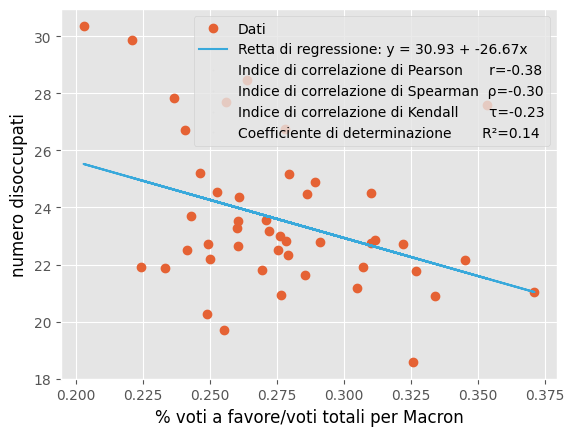

Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.21.        
Il coefficiente di correlazione di Pearson è però un indice poco robusto agli outlier e qui ve ne sono diversi.        
Inoltre il coefficiente di determinazione che fornisce informazioni sulla bontà di adattamento del modello(lineare) ai dati è molto basso(è pari a 0.05).       
È quindi più opportuno tenere in considerazione il coefficiente di correlazione di Spearman che è pari a 0.36.        
Secondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente.        
Tra 0.2 e 0.39 è debole, quindi esiste una correlazione debole, nei vari dipartimenti, tra voto a Macron nel primo turno e numero di disoccupati.


In [9]:
# Correlazione n.2
# Esiste una correlazione, in un dato dipartimento, tra voto a Macron nel primo turno e disoccupazione?

get_correlazione(df_risultati_elezioni_presidenziali_1_turno, 'MACRON', 'disoccupazione', '% voti a favore/voti totali per Macron', 'numero disoccupati')

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a -0.38. \
       \nIl coefficiente di correlazione di Pearson è però un indice poco robusto agli outlier e qui ve ne sono diversi. \
       \nInoltre il coefficiente di determinazione che fornisce informazioni sulla bontà di adattamento del modello(lineare) ai dati è molto basso(è pari a 0.14).\
       \nÈ quindi più opportuno tenere in considerazione il coefficiente di correlazione di Spearman che è pari a -0.30. \
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0.2 e 0.39 è debole, quindi esiste una correlazione debole, nei vari dipartimenti, tra voto a Macron nel primo turno e numero di disoccupati.')

In [ ]:
# Correlazione n.3
# Esiste una correlazione, in un dato dipartimento, tra voto a Macron nel primo turno e tasso di vaccinazione?

get_correlazione(df_risultati_elezioni_presidenziali_1_turno, 'MACRON', 'vaccinazioni', '% voti a favore/voti totali per Macron', 'tasso di vaccinazione')

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.39. \
       \nIl coefficiente di correlazione di Pearson è però un indice poco robusto agli outlier e qui ve ne sono diversi. \
       \nInoltre il coefficiente di determinazione che fornisce informazioni sulla bontà di adattamento del modello(lineare) ai dati è molto basso(è pari a 0.15).\
       \nÈ quindi più opportuno tenere in considerazione il coefficiente di correlazione di Spearman che è pari a 0.34. \
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0.2 e 0.39 è debole, quindi esiste una correlazione debole, nei vari dipartimenti, tra voto a Macron nel primo turno e tasso di vaccinazione.')

In [ ]:
# Correlazione n.4
# Esiste una correlazione, in un dato dipartimento, tra voto a Le Pen nel primo turno e reddito dichiarato pro capite?

get_correlazione(df_risultati_elezioni_presidenziali_1_turno, 'LE PEN', 'reddito_pro_capite', '% voti a favore/voti totali per Le Pen', 'reddito pro capite')

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a -0.73.\
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0.6 e 0.79 è forte, quindi esiste una correlazione forte, nei vari dipartimenti, tra voto a Le Pen nel primo turno e reddito pro capite.')

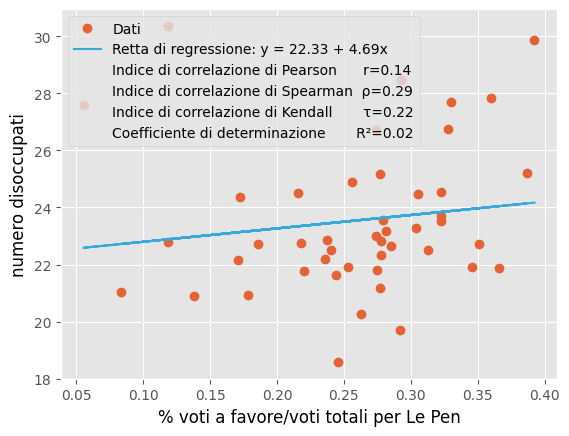

Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a -0.51.       
Secondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente.        
Tra 0.4 e 0.59 è moderata, quindi esiste una correlazione moderata, nei vari dipartimenti, tra voto a Le Pen nel primo turno e numero di disoccupati.


In [10]:
# Correlazione n.5
# Esiste una correlazione, in un dato dipartimento, tra voto a Le Pen nel primo turno e disoccupazione?

get_correlazione(df_risultati_elezioni_presidenziali_1_turno, 'LE PEN', 'disoccupazione', '% voti a favore/voti totali per Le Pen', 'numero disoccupati')

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.14.\
       \nInoltre il coefficiente di determinazione che fornisce informazioni sulla bontà di adattamento del modello(lineare) ai dati è molto basso(è pari a 0.02).\
       \nÈ quindi più opportuno tenere in considerazione il coefficiente di correlazione di Spearman che è pari a 0.29. \
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0.2 e 0.39 è debole, quindi esiste una correlazione moderata, nei vari dipartimenti, tra voto a Le Pen nel primo turno e numero di disoccupati.')

In [ ]:
# Correlazione n.6
# Esiste una correlazione, in un dato dipartimento, tra voto a Le Pen nel primo turno e tasso di vaccinazione?

get_correlazione(df_risultati_elezioni_presidenziali_1_turno, 'LE PEN', 'vaccinazioni', '% voti a favore/voti totali per Le Pen', 'tasso di vaccinazione')

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.25. \
       \nIl coefficiente di correlazione di Pearson è però un indice poco robusto agli outlier e qui ve ne sono diversi. \
       \nInoltre il coefficiente di determinazione che fornisce informazioni sulla bontà di adattamento del modello(lineare) ai dati è molto basso(è pari a 0.06).\
       \nÈ quindi più opportuno tenere in considerazione il coefficiente di correlazione di Spearman che è pari a 0.12. \
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0 e 0.19 è molto debole, quindi esiste una correlazione molto debole, nei vari dipartimenti, tra voto a Le Pen nel primo turno e tasso di vaccinazione.')

In [ ]:
# Correlazione n.7
# Esiste una correlazione, in un dato dipartimento, tra voto a Melenchon nel primo turno e reddito dichiarato pro capite?

get_correlazione(df_risultati_elezioni_presidenziali_1_turno, 'MÉLENCHON', 'reddito_pro_capite', '% voti a favore/voti totali per Mélenchon', 'reddito pro capite')

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.35. \
       \nIl coefficiente di correlazione di Pearson è però un indice poco robusto agli outlier e qui ve ne sono pochi ma grandi in valore assoluto. \
       \nInoltre il coefficiente di determinazione che fornisce informazioni sulla bontà di adattamento del modello(lineare) ai dati è molto basso(è pari a 0.12).\
       \nÈ quindi più opportuno tenere in considerazione il coefficiente di correlazione di Spearman che è pari a 0.61. \
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0.6 e 0.79 è forte, quindi esiste una correlazione forte, nei vari dipartimenti, tra voto a Melenchon nel primo turno e e reddito pro capite.')

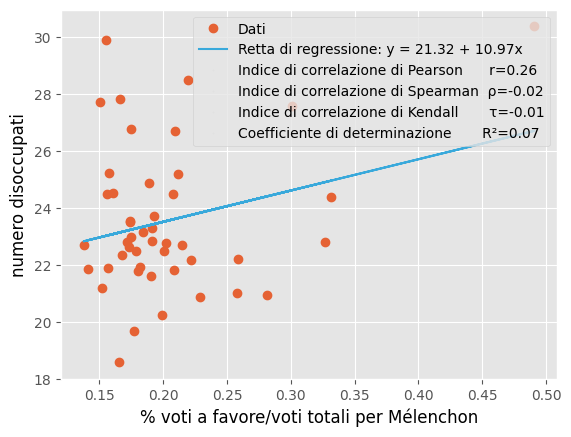

Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.65.       
Secondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente.        
Tra 0.6 e 0.79 è forte, quindi esiste una correlazione forte, nei vari dipartimenti, tra voto a Mélenchon nel primo turno e numero di disoccupati.


In [11]:
# Correlazione n.8
# Esiste una correlazione, in un dato dipartimento, tra voto a Melenchon nel primo turno e disoccupazione?

get_correlazione(df_risultati_elezioni_presidenziali_1_turno, 'MÉLENCHON', 'disoccupazione', '% voti a favore/voti totali per Mélenchon', 'numero disoccupati')

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.26.\
       \nInoltre il coefficiente di determinazione che fornisce informazioni sulla bontà di adattamento del modello(lineare) ai dati è molto basso(è pari a 0.07).\
       \nÈ quindi più opportuno tenere in considerazione il coefficiente di correlazione di Spearman che è pari a -0.02. \
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nEsiste una correlazione molto debole, nei vari dipartimenti, tra voto a Mélenchon nel primo turno e numero di disoccupati.')

In [ ]:
# Correlazione n.9
# Esiste una correlazione, in un dato dipartimento, tra voto a Melenchon nel primo turno e tasso di vaccinazione?

get_correlazione(df_risultati_elezioni_presidenziali_1_turno, 'MÉLENCHON', 'vaccinazioni', '% voti a favore/voti totali per Melenchon', 'tasso di vaccinazione')

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a -0.64.\
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0.6 e 0.79 è forte, quindi esiste una correlazione forte, nei vari dipartimenti, tra voto a Melenchon nel primo turno e vaccinazioni.')

In [ ]:
# Correlazione n.10
# Esiste una correlazione, in un dato dipartimento, tra voto a Ensemble/RN/Nupes/LR nel primo turno delle legislative e reddito pro capite?

get_correlazione(df_risultati_elezioni_legislative_1_turno, 'ENS', 'reddito_pro_capite', '% voti a favore/voti totali per Ensemble', 'reddito pro capite', is_legislative=True)

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.59.\
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0.4 e 0.59 è moderata, quindi esiste una correlazione moderata, nei vari dipartimenti, tra voto a Ensemble nel primo turno e reddito pro capite.')

get_correlazione(df_risultati_elezioni_legislative_1_turno, 'RN', 'reddito_pro_capite', '% voti a favore/voti totali per RN', 'reddito pro capite', is_legislative=True)

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a -0.67.\
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0.6 e 0.79 è forte, quindi esiste una correlazione forte, nei vari dipartimenti, tra voto a RN nel primo turno e reddito pro capite.')

get_correlazione(df_risultati_elezioni_legislative_1_turno, 'NUP', 'reddito_pro_capite', '% voti a favore/voti totali per Nupes', 'reddito pro capite', is_legislative=True)

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.33. \
       \nIl coefficiente di correlazione di Pearson è però un indice poco robusto agli outlier e qui ve ne sono pochi ma grandi in valore assoluto. \
       \nInoltre il coefficiente di determinazione che fornisce informazioni sulla bontà di adattamento del modello(lineare) ai dati è molto basso(è pari a 0.11).\
       \nÈ quindi più opportuno tenere in considerazione il coefficiente di correlazione di Spearman che è pari a 0.35. \
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0.2 e 0.39 è debole, quindi esiste una correlazione debole, nei vari dipartimenti, tra voto a Nupes nel primo turno e reddito pro capite.')

get_correlazione(df_risultati_elezioni_legislative_1_turno, 'LR', 'reddito_pro_capite', '% voti a favore/voti totali per LR', 'reddito pro capite', is_legislative=True)

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a -0.14. \
       \nIl coefficiente di correlazione di Pearson è però un indice poco robusto agli outlier e qui ve ne sono diversi e grandi in valore assoluto. \
       \nInoltre il coefficiente di determinazione che fornisce informazioni sulla bontà di adattamento del modello(lineare) ai dati è molto basso(è pari a 0.02).\
       \nÈ quindi più opportuno tenere in considerazione il coefficiente di correlazione di Spearman che è comunque pari a -0.14. \
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0 e 0.19 è molto debole, quindi esiste una correlazione molto debole, nei vari dipartimenti, tra voto a LR nel primo turno e reddito pro capite.')

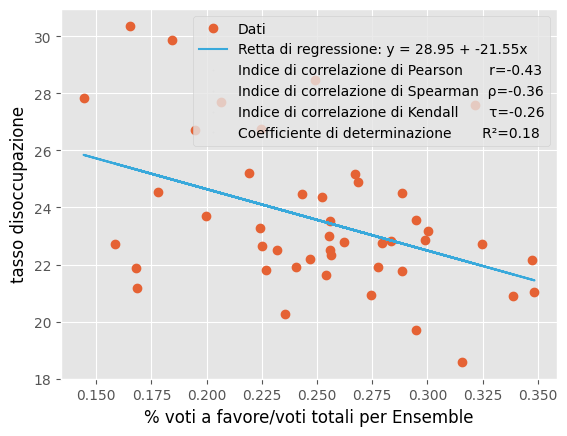

Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a -0.43.        
Il coefficiente di correlazione di Pearson è però un indice poco robusto agli outlier e qui ve ne sono diversi.        
Inoltre il coefficiente di determinazione che fornisce informazioni sulla bontà di adattamento del modello(lineare) ai dati è molto basso(è pari a 0.18).       
È quindi più opportuno tenere in considerazione il coefficiente di correlazione di Spearman che è pari a -0.36.        
Secondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente.        
Tra 0.4 e 0.49 è moderata, quindi esiste una correlazione debole, nei vari dipartimenti, tra voto a Ensemble nel primo turno e disoccupazione.


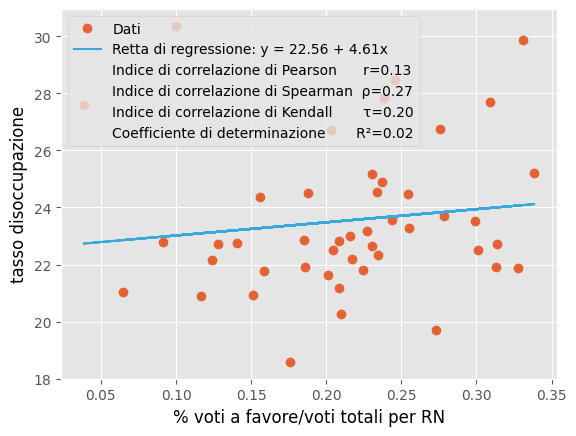

Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Spearman è pari a 0.27.       
Secondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente.        
Tra 0.2 e 0.39 è debole, quindi esiste una correlazione moderata, nei vari dipartimenti, tra voto a RN nel primo turno e disoccupazione.


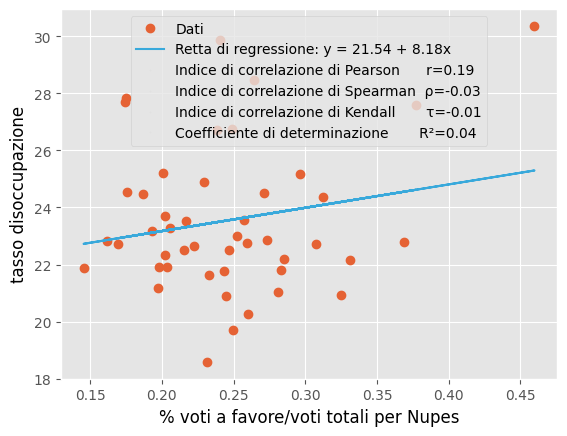

Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Spearman è pari a 0.19.       
Secondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente.        
Esiste una correlazione molto debole, nei vari dipartimenti, tra voto a Nupes nel primo turno e disoccupazione.


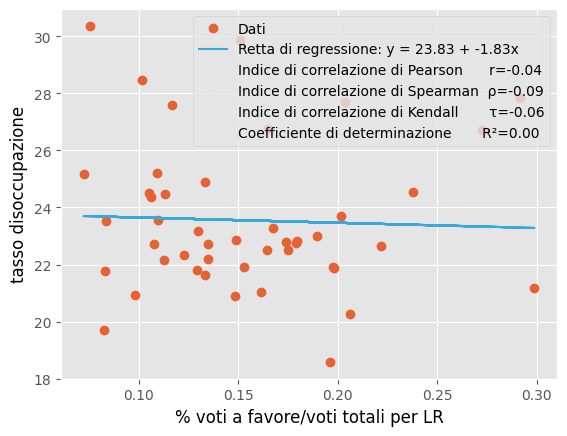

Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Spearman è pari a -0.09.       
Secondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente.        
Esiste una correlazione molto debole, nei vari dipartimenti, tra voto a LR nel primo turno e disoccupazione.


In [24]:
# Correlazione n.11
# Esiste una correlazione, in un dato dipartimento, tra voto a Ensemble/RN/Nupes/LR nel primo turno delle legislative e disoccupazione?

get_correlazione(df_risultati_elezioni_legislative_1_turno, 'ENS', 'disoccupazione', '% voti a favore/voti totali per Ensemble', 'tasso disoccupazione', is_legislative=True)

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a -0.43. \
       \nIl coefficiente di correlazione di Pearson è però un indice poco robusto agli outlier e qui ve ne sono diversi. \
       \nInoltre il coefficiente di determinazione che fornisce informazioni sulla bontà di adattamento del modello(lineare) ai dati è molto basso(è pari a 0.18).\
       \nÈ quindi più opportuno tenere in considerazione il coefficiente di correlazione di Spearman che è pari a -0.36. \
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0.4 e 0.49 è moderata, quindi esiste una correlazione debole, nei vari dipartimenti, tra voto a Ensemble nel primo turno e disoccupazione.')

get_correlazione(df_risultati_elezioni_legislative_1_turno, 'RN', 'disoccupazione', '% voti a favore/voti totali per RN', 'tasso disoccupazione', is_legislative=True)

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Spearman è pari a 0.27.\
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0.2 e 0.39 è debole, quindi esiste una correlazione moderata, nei vari dipartimenti, tra voto a RN nel primo turno e disoccupazione.')

get_correlazione(df_risultati_elezioni_legislative_1_turno, 'NUP', 'disoccupazione', '% voti a favore/voti totali per Nupes', 'tasso disoccupazione', is_legislative=True)

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Spearman è pari a 0.19.\
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nEsiste una correlazione molto debole, nei vari dipartimenti, tra voto a Nupes nel primo turno e disoccupazione.')

get_correlazione(df_risultati_elezioni_legislative_1_turno, 'LR', 'disoccupazione', '% voti a favore/voti totali per LR', 'tasso disoccupazione', is_legislative=True)

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Spearman è pari a -0.09.\
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nEsiste una correlazione molto debole, nei vari dipartimenti, tra voto a LR nel primo turno e disoccupazione.')


In [ ]:
# Correlazione n.12
# Esiste una correlazione, in un dato dipartimento, tra voto a Ensemble/RN/Nupes/LR nel primo turno delle legislative e tasso di vaccinazione?

get_correlazione(df_risultati_elezioni_legislative_1_turno, 'ENS', 'vaccinazioni', '% voti a favore/voti totali per Ensemble', 'vaccinazioni', is_legislative=True)

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.24. \
       \nIl coefficiente di correlazione di Pearson è però un indice poco robusto agli outlier e qui ve ne sono diversi e grandi in valore assoluto. \
       \nInoltre il coefficiente di determinazione che fornisce informazioni sulla bontà di adattamento del modello(lineare) ai dati è molto basso(è pari a 0.06).\
       \nÈ quindi più opportuno tenere in considerazione il coefficiente di correlazione di Spearman che è pari a 0.25. \
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0.2 e 0.39 è debole, quindi esiste una correlazione debole, nei vari dipartimenti, tra voto a Ensemble nel primo turno e vaccinazioni.')

get_correlazione(df_risultati_elezioni_legislative_1_turno, 'RN', 'vaccinazioni', '% voti a favore/voti totali per RN', 'vaccinazioni', is_legislative=True)

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.16. \
       \nIl coefficiente di correlazione di Pearson è però un indice poco robusto agli outlier e qui ve ne sono diversi e grandi in valore assoluto. \
       \nInoltre il coefficiente di determinazione che fornisce informazioni sulla bontà di adattamento del modello(lineare) ai dati è molto basso(è pari a 0.02).\
       \nÈ quindi più opportuno tenere in considerazione il coefficiente di correlazione di Spearman che è pari a 0.06. \
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0 e 0.19 è molto debole, quindi esiste una correlazione molto debole, nei vari dipartimenti, tra voto a RN nel primo turno e vaccinazioni.')

get_correlazione(df_risultati_elezioni_legislative_1_turno, 'NUP', 'vaccinazioni', '% voti a favore/voti totali per Nupes', 'vaccinazioni', is_legislative=True)

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a -0.34. \
       \nIl coefficiente di correlazione di Pearson è però un indice poco robusto agli outlier e qui ve ne sono diversi. \
       \nInoltre il coefficiente di determinazione che fornisce informazioni sulla bontà di adattamento del modello(lineare) ai dati è molto basso(è pari a 0.12).\
       \nÈ quindi più opportuno tenere in considerazione il coefficiente di correlazione di Spearman che è pari a -0.11. \
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0 e 0.19 è molto debole, quindi esiste una correlazione molto debole, nei vari dipartimenti, tra voto a Nupes nel primo turno e vaccinazioni.')

get_correlazione(df_risultati_elezioni_legislative_1_turno, 'LR', 'vaccinazioni', '% voti a favore/voti totali per LR', 'vaccinazioni', is_legislative=True)

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a 0.05. \
       \nIl coefficiente di correlazione di Pearson è però un indice poco robusto agli outlier e qui ve ne sono diversi e grandi in valore assoluto. \
       \nInoltre il coefficiente di determinazione che fornisce informazioni sulla bontà di adattamento del modello(lineare) ai dati è addirittura nullo.\
       \nÈ quindi più opportuno tenere in considerazione il coefficiente di correlazione di Spearman che è pari a -0.07. \
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0 e 0.19 è molto debole, quindi esiste una correlazione molto debole, nei vari dipartimenti, tra voto a LR nel primo turno e vaccinazioni.')


In [ ]:
# Correlazione n.13
# Esiste una correlazione, in un dato dipartimento, tra tasso di vaccinazione e reddito dichiarato pro capite?

vaccinazioni_tutte_eta = df_vaccinazioni_covid[df_vaccinazioni_covid['etichetta_variabile'] == 'Tous âges']
df_tasso_vaccinazione = vaccinazioni_tutte_eta.groupby(['nome_dipartimento'], as_index=False)[['copertura_vaccinale_seconda_dose']].max()
#display(df_media_tasso_vaccinazione)

df_reddito_pro_capite = df_reddito_dipartimenti[['nome_dipartimento', 'reddito_pro_capite']]
#display(df_media_reddito)

df_final = pd.merge(df_tasso_vaccinazione, df_reddito_pro_capite, on='nome_dipartimento')
#display(df_final)

x = df_final['copertura_vaccinale_seconda_dose']
y = df_final['reddito_pro_capite']

calcola_correlazione(x, y, 'tasso di vaccinazione', 'reddito pro capite')

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a -0.14. \
       \nIl coefficiente di correlazione di Pearson è però un indice poco robusto agli outlier e qui sono pochi ma grandi in valore assoluto. \
       \nInoltre il coefficiente di determinazione che fornisce informazioni sulla bontà di adattamento del modello(lineare) ai dati è molto basso(è pari a 0.02).\
       \nÈ quindi più opportuno tenere in considerazione il coefficiente di correlazione di Spearman che è pari a -0.40. \
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0.4 e 0.59 è moderata, quindi esiste una correlazione moderata, nei vari dipartimenti, tra tasso di vaccinazione e reddito pro capite.')

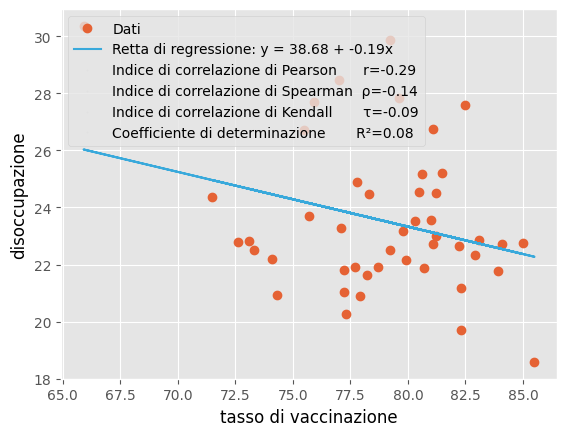

Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a -0.28.        
Il coefficiente di correlazione di Pearson è però un indice poco robusto agli outlier e qui ve ne sono pochi ma grandi in valore assoluto.        
Inoltre il coefficiente di determinazione che fornisce informazioni sulla bontà di adattamento del modello(lineare) ai dati è molto basso(è pari a 0.08).       
È quindi più opportuno tenere in considerazione il coefficiente di correlazione di Spearman che è pari a -0.29.        
Secondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente.        
Tra 0.2 e 0.39 è debole, quindi esiste una correlazione debole, nei vari dipartimenti, tra tasso di vaccinazione e tasso di disoccupazione.


In [33]:
# Correlazione n.14
# Esiste una correlazione, in un dato dipartimento, tra tasso di vaccinazione e tasso di disoccupazione?
vaccinazioni_tutte_eta = df_vaccinazioni_covid[df_vaccinazioni_covid['etichetta_variabile'] == 'Tous âges']
df_tasso_vaccinazione = vaccinazioni_tutte_eta.groupby(['nome_dipartimento'], as_index=False)[['copertura_vaccinale_seconda_dose']].max()
#display(df_media_tasso_vaccinazione)

df_media_disoccupazione = risultato_disoccupazione.groupby(['nome_dipartimento'], as_index=False)['disoccupazione_totale'].mean();
#display(df_media_reddito)

df_final = pd.merge(df_tasso_vaccinazione, df_media_disoccupazione, on='nome_dipartimento')
#display(df_final)

x = df_final['copertura_vaccinale_seconda_dose']
y = df_final['disoccupazione_totale']

calcola_correlazione(x, y, 'tasso di vaccinazione', 'disoccupazione')

print('Il valore del coefficiente che fa capo alla correlazione lineare ovvero il coefficiente di Pearson è pari a -0.28. \
       \nIl coefficiente di correlazione di Pearson è però un indice poco robusto agli outlier e qui ve ne sono pochi ma grandi in valore assoluto. \
       \nInoltre il coefficiente di determinazione che fornisce informazioni sulla bontà di adattamento del modello(lineare) ai dati è molto basso(è pari a 0.08).\
       \nÈ quindi più opportuno tenere in considerazione il coefficiente di correlazione di Spearman che è pari a -0.29. \
       \nSecondo Evans la forza della correlazione lineare viene decisa in base al valore assoluto di tale coefficiente. \
       \nTra 0.2 e 0.39 è debole, quindi esiste una correlazione debole, nei vari dipartimenti, tra tasso di vaccinazione e tasso di disoccupazione.')

In [ ]:
# Esistono altre correlazioni, anche spurie?
